# Clasificarea imaginilor utilizând Rețele Convoluționale



### Mihai Nan (mihai.nan@upb.ro)


## Importarea modulelor

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import torchvision.datasets as dset
import torch.nn.functional as F
import numpy as np
import scipy.misc
import json
import cv2
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
from livelossplot import PlotLosses
%matplotlib widget
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/home/skemo/.local/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Încărcarea setului de date MNIST

În cadrul acestui laborator ne propunem să rezolvăm o problemă de clasificare a imaginilor utilizând o rețea neurală convoluțională.

Pentru antrenarea acestei rețele vom folosi setul de date MNIST. Setul de date MNIST conține imagini alb negru cu cifre scrise de mână. Chiar dacă nu mai este de multă vreme un set de date provocator (existând deja clasificatoare cu o acuratețe de peste $99.9\%$), setul MNIST rămâne un set de date foarte folosit în special în cazul aplicațiilor cu scop didactic.

Acest set de date conține 70.000 de poze dintre care 60.000 sunt utilizate pentru antrenare și 10.000 pentru testare. Fiecare imagine conține un singur canal (grayscale) și are dimensiunea standard $28 \times 28$ pixeli.

Câteva exemple de imagini din setul de date MNIST:

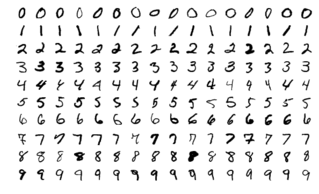


In [2]:
class Resize(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation

    def __call__(self, img):
        old_size = img.size  # old_size[0] is in (width, height) format
        ratio = float(self.size)/max(old_size)
        new_size = tuple([int(x * ratio) for x in old_size])
        return img.resize(new_size, resample=self.interpolation)

root = './mnist'
if not os.path.exists(root):
    os.mkdir(root)

trans = transforms.Compose([Resize(32), transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
# Dacă nu există deja, descarcă setul de date
train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

# Vom folosi batch-uri pentru antrenare (batch = o mulțime de imagini)
batch_size = 100

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

8.6%

14.9%

100.0%


Extracting ./mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist/MNIST/raw


100.0%
87.4%


Extracting ./mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



100.0%
100.0%


Extracting ./mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist/MNIST/raw

Extracting ./mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist/MNIST/raw



## Funcții pentru vizualizarea hărților de activare, filtrelor și caracteristicile modelului




In [3]:
def to_grayscale(image):
    shape = image.shape[0]
    image = torch.sum(image, dim=0, keepdim=True)
    image = torch.div(image, shape)
    return image

def show_activations(image, model):
    outputs = []
    names = []
    out_im = []
    modules = model.features

    for layer in modules:
        print(layer)
        image = layer(image)
        outputs.append(image)
        names.append(str(layer))

    for i in outputs:
        i = i.squeeze(0)
        grayscale = to_grayscale(i).squeeze(0)
        i = grayscale.data.cpu().numpy()
        out_im.append(i)

    fig = figure()
    rcParams["figure.figsize"]=(30,50)

    for i in range(len(out_im)):
        a = fig.add_subplot(8,4,i+1)

        imshow(1-out_im[i])
        axis('off')
        a.set_title(names[i].partition('(')[0], fontsize=20)

def show_filter_activations(image, model, chosen_layer):
    modules = model.features
    if chosen_layer < 0:
        chosen_layer = 0
    output = None
    name = None
    for cnt, layer in enumerate(modules):
        image = layer(image)

        if cnt == chosen_layer:
            output = image
            name = str(layer)

    filters = []
    output = output.data.squeeze()

    for i in range(output.shape[0]):
        filters.append(output[i,:,:])

    fig = figure()
    rcParams["figure.figsize"]=(30,50)
    title(name,fontsize=30)
    for i in range(len(filters)):
        a = fig.add_subplot(np.sqrt(len(filters))+1, np.sqrt(len(filters)),i+1)
        imshow(1-filters[i])
        plt.axis('off')

def show_conv_features(model, layer):
    wt_lyr = []
    for w in model.features:
        if isinstance(w, torch.nn.modules.conv.Conv2d):
            wt_lyr.append(w.weight.data)

    filters = []
    print(wt_lyr[layer].shape)
    for i in range(wt_lyr[layer].shape[0]):
        filters.append(wt_lyr[layer][i,:,:,:].sum(dim=0))
        filters[i].div(wt_lyr[layer].shape[1])

    fig = figure()
    rcParams["figure.figsize"]=(10,10)
    for i in range(int(np.sqrt(wt_lyr[layer].shape[0]**2))):
        a = fig.add_subplot(np.sqrt(wt_lyr[layer].shape[0])+1,np.sqrt(wt_lyr[layer].shape[0]),i+1)
        imshow(filters[i])
        plt.axis('off')

## Rețeaua LeNet 5

Există foarte multe arhitecturi neurale bazate pe straturi convoluționale care obțin rezultate spectaculoase pentru diverse sarcini de lucru ce presupun analizarea unor imagini: clasificarea imaginilor, segmentarea imaginilor, detecția obiectelor în imagini etc.

LeNet-5 reprezintă cea mai veche arhitectura convoluțională ce a fost propusă în anul 1998. Această arhitectură a fost proiectată de Yann LeCun *et al.* ( [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf)) cu scopul de recunoaște cifre scrise de mână în documente scanate.

### Arhitectura modelului neural

Această arhitectură a fost concepută pentru imagini de rezoluție mică și conține o adâncime mică (doar două straturi convoluționale) din cauza constrângerilor care existau în vremea respectivă la nivel de putere de calcul.

![alt text](https://i.imgur.com/VDOzp4t.jpg)

### Implementarea modelului neural

**TODO 1:** În blocul de cod următor avem definită o clasă ce reprezintă implementarea modelului neural. În constructorul acestei clase avem definite straturile pe care le aplică această rețea. Pentru această cerința va trebui să completați implementarea funcției **forward**.

In [9]:
class LeNet(nn.Module):
    def __init__(self, in_size, out_size):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(in_size, 6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(5*5*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, out_size)
        self.relu = nn.ReLU()
        self.features = [self.conv1, self.relu, self.pool, self.conv2, self.relu, self.pool]

    def forward(self, x):
        # TODO 1: Aplicați straturile rețelei
        # x -> Conv1 -> ReLU -> Pool -> Conv2 -> ReLU -> Pool -> Reshape -> FC1 -> ReLU -> FC2 -> ReLU -> FC3 -> Y

        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = torch.flatten(x, 1)

        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        y = self.fc3(x)

        return y

    def name(self):
        return "LeNet"

## Instanțierea Modelului

Framework-ul pytorch permite rularea modelului neural pe GPU. Pentru acest lucru, putem folosi instrucțiunea:

```
model = model.cuda()
```

In [10]:
use_cuda = torch.cuda.is_available()
model = LeNet(1, 10)
if use_cuda:
    model = model.cuda()

## Optimizatorul și Funcția de eroare

Pentru a putea estima valorile ponderilor modelului neural, avem nevoie de două concepte importante:


1.   Algoritmul de optimizare $-$ Pentru procesul de optimizare vom folosi algoritmul Stochastic Gradient Descent.
2.   Funcția de eroare $-$ Am văzut în cadrul cursului că pentru o problemă de clasificare multi-clasă putem utiliza funcția de eroarea Cross-Entropy împreună cu funcția de activare Softmax. În pytorch avem clasa ```torch.nn.CrossEntropyLoss```, iar în cadrul implementării din bibliotecă deja se aplică înainte funcția de activare Softmax. Astfel, nu este nevoie să transformăm într-o distribuție de probabilitate predicția rețelei. 





In [11]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## Antrenarea și Validarea modelului

**Cerința 2**: Va trebui să completați algoritmul de antrenare utilizat pentru estimarea ponderilor rețelei neurale. Pașii pe care trebuie să îi implementați sunt următorii:



1.   Resetarea gradienților (Hint: ```zero_grad()```)
2.   Determinarea predicției rețelei neurale
3.   Calcularea funcției de eroare
4.   Aplicarea algoritmului Backward.

    4.1. Calcularea gradienților

    4.2. Actualizarea ponderilor rețelei în funcție de valoarea gradienților
5.   Determinarea numărului de exemple clasificate corect

În ceea ce privește procesul de evaluare, atunci nu o să mai fie nevoie de actualizarea ponderilor.



In [14]:
liveloss = PlotLosses()

for epoch in range(10):
    # Antrenarea modelului
    model.train()
    train_ave_loss = 0
    train_correct_cnt, total_cnt = 0, 0
    for batch_idx, (x, target) in enumerate(train_loader):
        # Pas 1: Resetarea gradienților (Hint: zero_grad())
        # TODO 2.1
        model.zero_grad()
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)

        # Pas 2: Determinăm predicția rețelei
        # TODO 2.2: out = ...
        out = model(x)
        # Pas 3: Calculăm valoarea funcției de eroare
        # TODO 2.3: loss = ...
        loss = criterion(out, target)

        # Pasul 4: Aplicăm algoritmul Backward
        # Pasul 4.1 din Backward: Calculăm gradienții
        # TODO 2.4.1.
        loss.backward()


        # Pasul 4.2 din Backward: Actualizăm ponderile rețelei în funcție de valoarea gradienților
        # TODO 2.4.2


        # Actualizăm valoarea erorii medii pentru setul de antrenare
        train_ave_loss = train_ave_loss * 0.9 + loss.item() * 0.1
        # Pasul 5: Determinăm câte exemple au fost clasificate corect
        # TODO 2.5: correct = ...
        correct = 0

        if torch.argmax(out) == target:
            correct = 1

        total_cnt += x.data.size()[0]
        train_correct_cnt += correct

        if (batch_idx+1) % 100 == 0 or (batch_idx+1) == len(train_loader):
            print('==>>> [TRAIN] Epoch: {}, batch index: {}, train loss: {:.6f}'.format(
                epoch, batch_idx+1, train_ave_loss))
    train_acc = train_correct_cnt * 1.0 / total_cnt

    # Evaluarea modelului
    model.eval()
    test_correct_cnt, test_ave_loss = 0, 0
    total_cnt = 0
    for batch_idx, (x, target) in enumerate(test_loader):
        if use_cuda:
            x, target = x.cuda(), target.cuda()
        x, target = Variable(x), Variable(target)

        # Pasul 6: Determinăm predicția rețelei
        # TODO 2.6: out = ...
        out = model(x)

        # Pasul 7: Calculăm valoarea funcției de eroare
        # TODO 2.7: loss = ...
        loss = criterion(out, target)
        # Actualizăm valoarea erorii medii pentru setul de testare
        test_ave_loss = test_ave_loss * 0.9 + loss.item() * 0.1
        # Pasul 8: Determinăm câte exemple au fost clasificate corect
        # TODO 2.8 correct = ...
        correct = 0
        if torch.argmax(out) == target:
            correct = 1
        total_cnt += x.data.size()[0]
        test_correct_cnt += correct

        if(batch_idx+1) % 100 == 0 or (batch_idx+1) == len(test_loader):
            print('==>>> [TEST] Epoch: {}, batch index: {}, test loss: {:.6f}, acc: {:.3f}'.format(
                epoch, batch_idx+1, test_ave_loss, test_correct_cnt * 1.0 / total_cnt))
    test_acc = test_correct_cnt * 1.0 / total_cnt
    liveloss.update({
        'log loss': train_ave_loss,
        'val_log loss': test_ave_loss,
        'accuracy': train_acc,
        'val_accuracy': test_acc
    })
    liveloss.draw()

tensor([[ 0.0418, -0.0769, -0.0828, -0.0657, -0.0677, -0.0934, -0.0224,  0.0066,
         -0.1060, -0.0199],
        [ 0.0388, -0.0777, -0.0816, -0.0689, -0.0676, -0.0925, -0.0197,  0.0075,
         -0.1039, -0.0194],
        [ 0.0387, -0.0770, -0.0814, -0.0672, -0.0696, -0.0922, -0.0214,  0.0111,
         -0.1050, -0.0175],
        [ 0.0363, -0.0730, -0.0883, -0.0655, -0.0737, -0.0965, -0.0272,  0.0043,
         -0.1070, -0.0198],
        [ 0.0409, -0.0756, -0.0821, -0.0647, -0.0688, -0.0913, -0.0221,  0.0078,
         -0.1047, -0.0184],
        [ 0.0367, -0.0738, -0.0858, -0.0631, -0.0710, -0.0972, -0.0232,  0.0018,
         -0.1106, -0.0179],
        [ 0.0415, -0.0706, -0.0849, -0.0666, -0.0662, -0.0936, -0.0227,  0.0092,
         -0.1052, -0.0224],
        [ 0.0416, -0.0740, -0.0865, -0.0609, -0.0703, -0.0945, -0.0268,  0.0053,
         -0.1095, -0.0247],
        [ 0.0403, -0.0768, -0.0845, -0.0658, -0.0686, -0.0906, -0.0239,  0.0044,
         -0.1054, -0.0202],
        [ 0.0334, -

RuntimeError: Boolean value of Tensor with more than one value is ambiguous

In [ ]:
class NormalizeInverse(transforms.Normalize):
    """
    Undoes the normalization and returns the reconstructed images in the input domain.
    """

    def __init__(self, mean, std):
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_gray_image(data_set, rand=False):
    size = len(data_set)
    axis('off')
    if rand:
      index = random.randint(0, size)
    else:
      index = 10
    sample = data_set[index]
    image_tensor = sample[0]
    inv_normalize = transforms.Normalize(
                        mean=[-0.5],
                        std=[1.0]
                    )
    image = inv_normalize(image_tensor)
    image = image.squeeze().numpy()
    imshow(image)
    return sample[0]

# Testarea calitativă

Pentru a testa calitativ modelul nostru, extragem o imagine din setul de testare, determinăm predicția modelului pentru această imagine și verificăm distribuția de probabilitate obținută.

In [ ]:
tensor = show_gray_image(test_set, rand=True)

In [ ]:
input = tensor.unsqueeze(0)
print(input.size())
out = model(input)
softmax = nn.Softmax(dim=1)
prob = softmax(out)


%matplotlib inline
plt.stem(list(range(10)), prob[0].detach().numpy(), use_line_collection=True)
plt.xlabel('Class')
plt.ylabel('Probability')
plt.show()

## Activation maps for each layer

In [ ]:
batch = tensor.unsqueeze(0)
print("Batch size: ", batch.size())
if use_cuda:
    batch = batch.cuda()
x = Variable(batch)
output = model(x)
show_activations(x, model)

## Filter activations for Conv2d(1, 6, 5x5, 1)

In [ ]:
show_filter_activations(x, model, 0)

## Filter activations for ReLU

In [ ]:
show_filter_activations(x, model, 1)

## Filter activations for AvgPool2d

In [ ]:
show_filter_activations(x, model, 2)

## Filter activations for Conv2d(6, 16, 5x5, 1)

In [ ]:
show_filter_activations(x, model, 3)

## Filter activations for ReLU

In [ ]:
show_filter_activations(x, model, 4)

## Filter activations for AvgPool2d

In [ ]:
show_filter_activations(x, model, 5)

## Features for Conv2d(1, 6, 5x5, 1)

In [ ]:
show_conv_features(model, 0)

## Features for Conv2d(6, 16, 5x5, 1)

In [ ]:
show_conv_features(model, 1)